In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import sys

# import feature_engineering
warnings.filterwarnings('ignore')

# Xử lý text
import re
from collections import Counter

# Feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD

# Data transformation
from scipy import stats
from scipy.stats import boxcox

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from feature_engineering import plot_numerical_distribution

In [3]:
# Đọc dữ liệu train_raw
df = pd.read_csv('../data/cleaned/train_raw.csv')
print(f"Shape của dữ liệu: {df.shape}")
print(f"Số cột: {df.shape[1]}")
df.head()


Shape của dữ liệu: (8000, 21)
Số cột: 21


,budget,cast_top5,certification_US,collection_id,directors,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_count,vote_average
0,2.000000e+06,"Ethan Hawke,Julie Delpy,Wiley Wiggins,Bill Wis...",NR,-1.0,Richard Linklater,"Animation,Drama,Fantasy","dreams,philosophy,parallel world,existence,adu...",en,Waking Life,Waking Life is about a young man in a persiste...,4.3827,"IFC Productions,Thousand Words,Detour Filmprod...",US,2001-10-19,3176880.0,101.0,en,Dreams. What are they? An escape from reality ...,Waking Life,914,7.470
1,3.000000e+06,"Erkan Kolçak Köstendil,Ali Atay,Şebnem Bozoklu...",NR,-1.0,Can Ulkay,"History,Drama,War","world war i,ice cream,gallipoli campaign,broke...",tr,Türk İşi Dondurma,"In 1915, two Turks in Australia make a living ...",1.7656,Dijital Sanatlar,TR,2019-03-15,1289283.0,120.0,"tr,en",NaN,Turkish Ice Cream,42,5.900
2,4.000000e+06,"Dennis Hopper,Asia Argento,Helen Shaver,Lochly...",R,-1.0,Paul Lynch,"Crime,Drama,Thriller","kidnapping,hostage,psychopath,deputy sheriff,s...",en,The Keeper,When an apparently exemplary cop abducts and s...,7.2882,Peace Arch Films,"GB,CA",2004-05-14,73788.0,95.0,en,NaN,The Keeper,32,4.375
3,1.050910e+07,"Jimmy Bennett,Adam Taylor Gordon,Ashley Rose O...",G,-1.0,"Larry Leichliter,Bill Melendez","Animation,Comedy,Family,TV Movie","holiday,dog",en,"I Want a Dog for Christmas, Charlie Brown",Linus and Lucy's younger brother Rerun wants a...,5.2636,"Lee Mendelson Film Productions,Charles M. Schu...",US,2003-12-09,0.0,49.0,en,NaN,"I Want a Dog for Christmas, Charlie Brown",55,5.845
4,6.300000e+05,"John Schneider,Luke Benjamin Bernard,Matthew F...",PG-13,-1.0,Curtis Graham,Drama,Unknown,en,The Favorite,Inspired by the true events of Luke Benjamin B...,3.4839,Unknown,US,2019-09-13,36800000.0,108.0,en,"One brother fights for his life, the other fig...",The Favorite,2,6.000


# 1. FEATURE ENGINEERING CHO DỮ LIỆU DẠNG BẢNG (Transformation)

Cần tạo bản sao của dataframe gốc để thực hiện feature engineering mà không làm thay đổi dữ liệu ban đầu.
- Tạo deep copy của dataframe để đảm bảo thay đổi không ảnh hưởng đến dữ liệu gốc
- Lưu trữ trong biến mới để dễ quản lý

In [4]:
df_fe = df.copy()

## 1.1. Xử lý dữ liệu thời gian

**Vấn đề**

Ngày phát hành (release_date) là dữ liệu datetime nhưng cần tách thành các features riêng biệt (năm, tháng, ngày) và tạo features có ý nghĩa như mùa, ngày trong tuần.

**Ý tưởng giải quyết:**
- **Temporal Features**: Tách năm, tháng, ngày, quý từ datetime
- **Day of Week**: Ngày trong tuần (0=Monday, 6=Sunday)
- **Weekend Indicator**: Binary feature cho cuối tuần (thường có doanh thu cao hơn)
- **Movie Age**: Tuổi của phim tính từ năm phát hành đến hiện tại

**Kỹ thuật xử lý:**
- Sử dụng `pd.to_datetime()` để chuyển đổi sang datetime
- Dùng `.dt` accessor để extract year, month, day, quarter, dayofweek
- Tạo binary feature cho weekend (dayofweek >= 5)


In [5]:
# Xử lý release_date features
if 'release_date' in df_fe.columns:
    df_fe['release_date'] = pd.to_datetime(df_fe['release_date'], errors='coerce')
    if 'release_year' not in df_fe.columns:
        df_fe['release_year'] = df_fe['release_date'].dt.year
    if 'release_month' not in df_fe.columns:
        df_fe['release_month'] = df_fe['release_date'].dt.month
    if 'release_day' not in df_fe.columns:
        df_fe['release_day'] = df_fe['release_date'].dt.day
    df_fe['release_quarter'] = df_fe['release_date'].dt.quarter
    df_fe['release_dayofweek'] = df_fe['release_date'].dt.dayofweek
    df_fe['release_is_weekend'] = (df_fe['release_dayofweek'] >= 5).astype(int)

# Tính tuổi của phim
if 'release_year' in df_fe.columns:
    current_year = 2025  # Hoặc có thể dùng pd.Timestamp.now().year
    df_fe['movie_age'] = current_year - df_fe['release_year']

df_fe.head(5)

,budget,cast_top5,certification_US,collection_id,directors,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_count,vote_average,release_year,release_month,release_day,release_quarter,release_dayofweek,release_is_weekend,movie_age
0,2.000000e+06,"Ethan Hawke,Julie Delpy,Wiley Wiggins,Bill Wis...",NR,-1.0,Richard Linklater,"Animation,Drama,Fantasy","dreams,philosophy,parallel world,existence,adu...",en,Waking Life,Waking Life is about a young man in a persiste...,4.3827,"IFC Productions,Thousand Words,Detour Filmprod...",US,2001-10-19,3176880.0,101.0,en,Dreams. What are they? An escape from reality ...,Waking Life,914,7.470,2001,10,19,4,4,0,24
1,3.000000e+06,"Erkan Kolçak Köstendil,Ali Atay,Şebnem Bozoklu...",NR,-1.0,Can Ulkay,"History,Drama,War","world war i,ice cream,gallipoli campaign,broke...",tr,Türk İşi Dondurma,"In 1915, two Turks in Australia make a living ...",1.7656,Dijital Sanatlar,TR,2019-03-15,1289283.0,120.0,"tr,en",NaN,Turkish Ice Cream,42,5.900,2019,3,15,1,4,0,6
2,4.000000e+06,"Dennis Hopper,Asia Argento,Helen Shaver,Lochly...",R,-1.0,Paul Lynch,"Crime,Drama,Thriller","kidnapping,hostage,psychopath,deputy sheriff,s...",en,The Keeper,When an apparently exemplary cop abducts and s...,7.2882,Peace Arch Films,"GB,CA",2004-05-14,73788.0,95.0,en,NaN,The Keeper,32,4.375,2004,5,14,2,4,0,21
3,1.050910e+07,"Jimmy Bennett,Adam Taylor Gordon,Ashley Rose O...",G,-1.0,"Larry Leichliter,Bill Melendez","Animation,Comedy,Family,TV Movie","holiday,dog",en,"I Want a Dog for Christmas, Charlie Brown",Linus and Lucy's younger brother Rerun wants a...,5.2636,"Lee Mendelson Film Productions,Charles M. Schu...",US,2003-12-09,0.0,49.0,en,NaN,"I Want a Dog for Christmas, Charlie Brown",55,5.845,2003,12,9,4,1,0,22
4,6.300000e+05,"John Schneider,Luke Benjamin Bernard,Matthew F...",PG-13,-1.0,Curtis Graham,Drama,Unknown,en,The Favorite,Inspired by the true events of Luke Benjamin B...,3.4839,Unknown,US,2019-09-13,36800000.0,108.0,en,"One brother fights for his life, the other fig...",The Favorite,2,6.000,2019,9,13,3,4,0,6


## 1.2. Xử lý dữ liệu dạng số (Numerical transformation)

Những attributes dạng số: budget, revenue, vote_average, vote_count, runtime, popularity

### 1.2.1. Data transformation

**a. Xử lý data phân phối lệch**

**Vấn đề:**

Các biến số như budget, revenue, runtime, vote_count hay popularity có phân phối lệch phải, những outlier này quan trọng nên không remove.
* Có những phim có budget và revenue cao làm dữ liệu lệch phải dẫn đến dùng khi dùng các model linear thì nhạy với với outlier lớn.

**Ý tưởng giải quyết**

Dùng log transformation, đưa các biến số về phân phối dạng chuẩn và giảm sức ảnh hưởng của outlier.

Công thức: $x_{new} = \ln(x + 1)$.

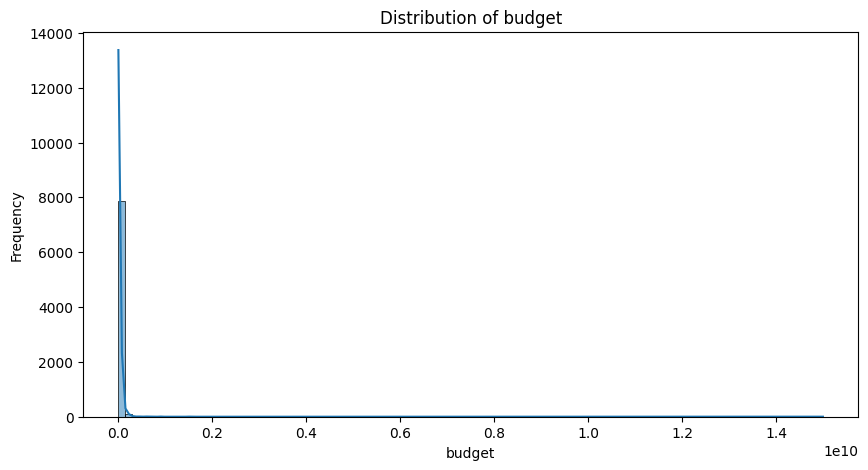

In [6]:
plot_numerical_distribution(df_fe, 'budget', 100)

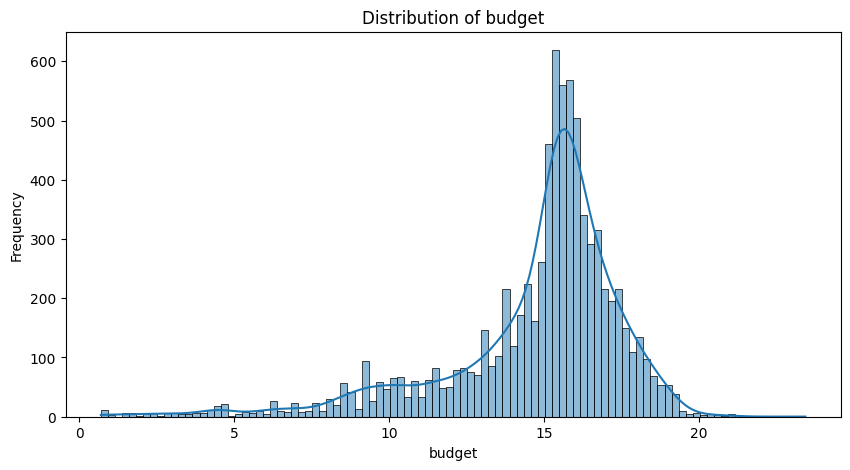

In [7]:
df_fe['budget'] = np.log1p(df_fe['budget'])
# df_fe['vote_count'] = np.log1p(df_fe['vote_count'])
df_fe['revenue'] = np.log1p(df_fe['revenue'])
plot_numerical_distribution(df_fe, 'budget', 100)

**b. Xử lý data có phân phối xấp xỉ Gauss và có outlier**

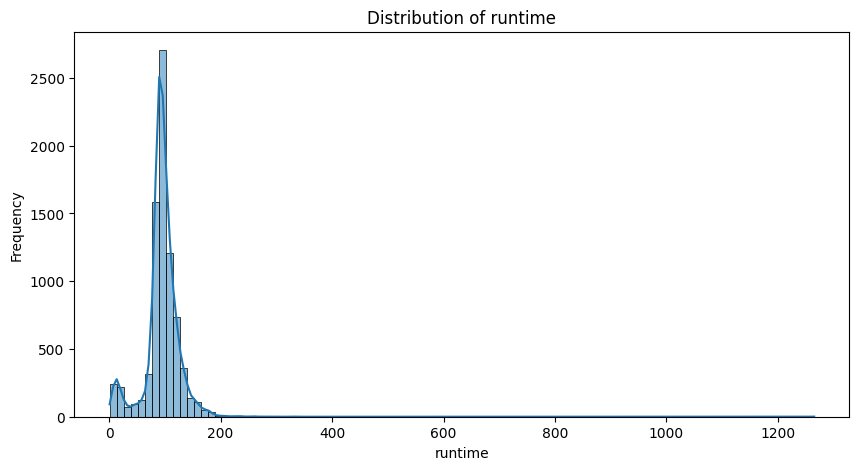

In [8]:
plot_numerical_distribution(df_fe, 'runtime', 100)

runtime có giá trị luôn lớn hơn 0, lệch phải, phần đuôi bên phải kéo dài hơn so với bên trái.

**Ý tưởng giải quyết:**

Dùng Box-cox transformation dùng mạnh cho dữ liệu dương, tự động tìm giá trị $\lambda$ tối ưu để biến dữ liệu này thành phân phối chuẩn nhất có thể.

**Kỹ thuật sử dụng:**
- Sử dụng `scipy.stats.boxcox()` để tìm lambda tối ưu và transform dữ liệu
- Xử lý missing values và giá trị <= 0 trước khi transform
- Lưu lambda để có thể inverse transform sau này nếu cần

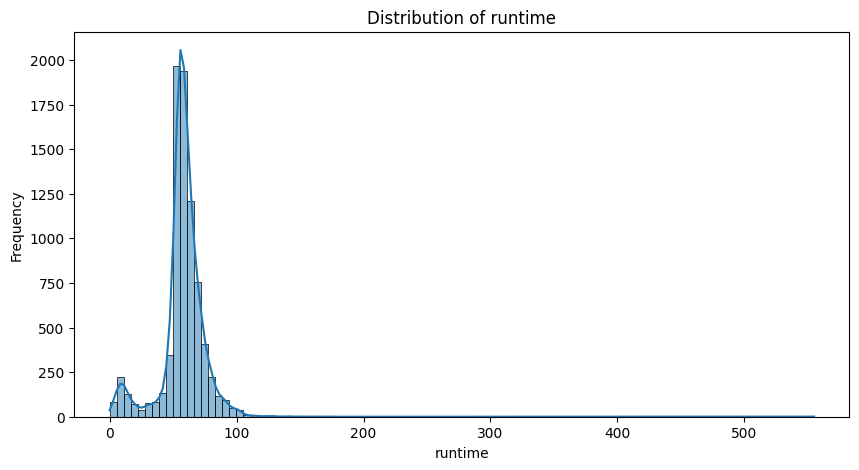

In [9]:
runtime_data = df_fe['runtime'].copy()
runtime_median = runtime_data.median()

min_runtime = runtime_data.min()
runtime_transformed, fitted_lambda = boxcox(runtime_data)
df_fe['runtime'] = runtime_transformed

plot_numerical_distribution(df_fe, 'runtime', 100)


**c. Xử lý Popularity với phân phối Multimodal**

**Vấn đề**

Cột `popularity` có phân phối multimodal (nhiều đỉnh) với 2-3 peaks rõ ràng và right-skewed tail. Phân phối này không phù hợp với các giả định của nhiều model machine learning (như normal distribution).

**Cách giải quyết:**
- Sử dụng log transformation để giảm skewness và làm phẳng các peaks

**Kỹ thuật sử dụng:**
- Sử dụng `np.log1p()` (log(1+x)) để tránh log(0) và xử lý giá trị nhỏ.
- So sánh kết quả và chọn transformation phù hợp nhất


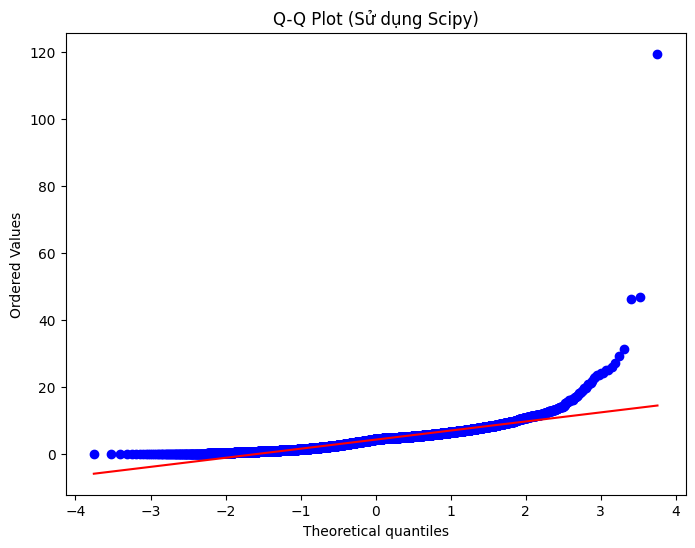

In [10]:
import scipy.stats as stats

plt.figure(figsize=(8, 6))
stats.probplot(df_fe['popularity'], dist="norm", plot=plt)
plt.title("Q-Q Plot (Sử dụng Scipy)")
plt.show()

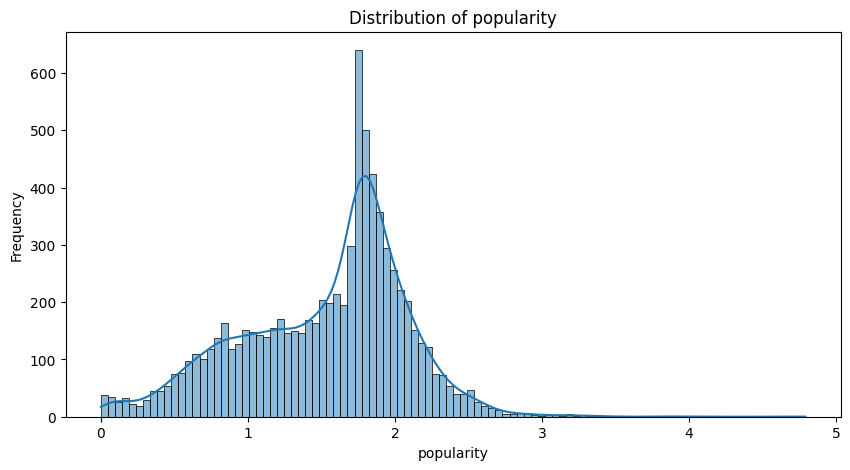

In [11]:
popularity_data = df_fe['popularity'].copy()

popularity_log = np.log1p(popularity_data)
df_fe['popularity'] = popularity_log
    
plot_numerical_distribution(df_fe, 'popularity', 100)

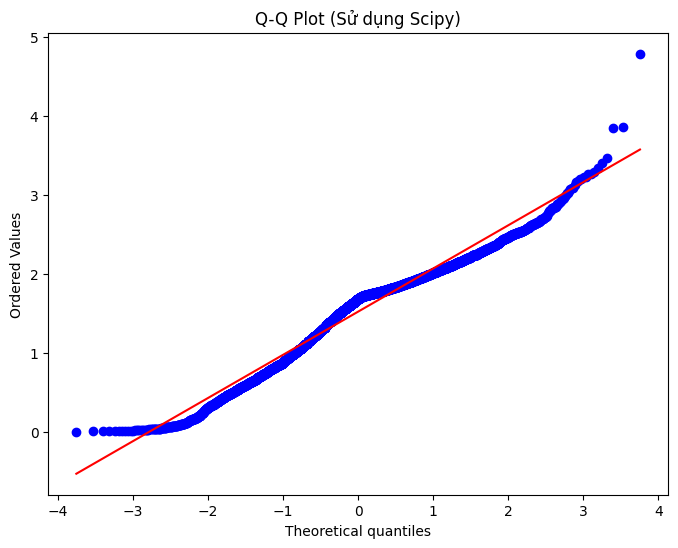

In [12]:
plt.figure(figsize=(8, 6))
stats.probplot(df_fe['popularity'], dist="norm", plot=plt)
plt.title("Q-Q Plot (Sử dụng Scipy)")
plt.show()

## 1.3. Xử lý categorical data

### 1.3.1. Xử lý cột Genres

Genres là dữ liệu categorical dạng multi-label (một phim có thể có nhiều thể loại), cần chuyển đổi thành features số có ý nghĩa. Số lượng genres và loại genres cụ thể có thể ảnh hưởng đến rating và doanh thu.

**Cách giải quyết**
- **Chuyển genres thành list**: Parse genres string thành list để xử lý dễ dàng hơn
- Thêm feature **num_genres**: Số lượng thể loại - phim có nhiều genres có thể có audience rộng hơn
- Sử dụng `MultiLabelBinarizer` từ sklearn để tự động tạo binary features cho tất cả genres unique
- **Binary Genre Features**: Mỗi genre có một cột riêng (1 nếu phim thuộc genre đó, 0 nếu không)

**Kỹ thuật sử dụng:**
- **Parse genres**: Split string bằng dấu phẩy và chuyển thành list, xử lý missing values (trả về empty list)
- **MultiLabelBinarizer**: 
  - `fit_transform()` trên list of lists để tạo binary matrix
  - Tự động tạo binary features cho tất cả genres unique trong dataset
  - Không cần chọn top genres thủ công, encode tất cả genres
- **Normalize tên cột**: Tên genre được normalize (lowercase, replace space với underscore) cho tên cột
- **Concatenation**: Kết hợp encoded genres với dataframe chính bằng `pd.concat()`


In [13]:
def parse_genres(genres_str):
    """Chuyển đổi genres string thành list"""
    if pd.isna(genres_str) or genres_str == '' or str(genres_str) == 'nan':
        return []
        
    genres_list = [g.strip() for g in str(genres_str).split(',') if g.strip()]
    return genres_list


if 'genres' in df_fe.columns:
    # a. Chuyển genres thành dạng list
    df_fe['genres_list'] = df_fe['genres'].apply(parse_genres)
    
    # Tính số lượng genres
    df_fe['num_genres'] = df_fe['genres_list'].apply(len) # này ngon
    
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df_fe['genres_list'])
    
    # Tạo DataFrame từ encoded genres
    genre_columns = [f'genre_{genre.lower().replace(" ", "_")}' for genre in mlb.classes_]
    genres_df = pd.DataFrame(genres_encoded, columns=genre_columns, index=df_fe.index)
    
    # Kết hợp với dataframe chính
    df_fe = pd.concat([df_fe, genres_df], axis=1)
    
    print(f"Thêm {len(mlb.classes_)} binary features")


Thêm 20 binary features


### 1.3.2. Xử lý cột cast_top_5

Cột `cast_top_5` chứa danh sách tên diễn viên (top 5 diễn viên chính) của mỗi phim, được lưu dưới dạng string phân cách bởi dấu phẩy. Số lượng diễn viên và sự hiện diện của các diễn viên nổi tiếng có thể ảnh hưởng đến doanh thu và rating của phim.

**Cách giải quyết:**
- **Chuyển cast thành list**: Parse cast string thành list để xử lý dễ dàng hơn
- **num_cast**: Số lượng diễn viên trong top 5 - phim có nhiều diễn viên nổi tiếng có thể thành công hơn
- **cast_list**: Lưu danh sách cast dưới dạng list để có thể sử dụng sau này (nếu cần)

**Kỹ thuật sử dụng:**
- **Parse cast**: Split string bằng dấu phẩy và chuyển thành list, xử lý missing values (trả về empty list)
- **Đếm số lượng**: Sử dụng `len()` để đếm số diễn viên
- **Binary feature**: Tạo feature `has_cast` bằng cách check xem list có rỗng hay không
- **Xử lý edge cases**: Xử lý các trường hợp đặc biệt như string rỗng, 'nan', hoặc missing values


In [14]:
cast_col = 'cast_top5'

# Chuyển cast thành dạng list
def parse_cast(cast_str):
    if pd.isna(cast_str) or cast_str == '' or str(cast_str) == 'nan':
        return []
    # Split bằng dấu phẩy và strip whitespace
    cast_list = [c.strip() for c in str(cast_str).split(',') if c.strip()]
    return cast_list

df_fe['cast_list'] = df_fe[cast_col].apply(parse_cast)
# Tính số lượng cast
df_fe['num_cast'] = df_fe['cast_list'].apply(len)


### 1.3.3. Xử lý cột directors

Cột `directors` chứa danh sách đạo diễn của mỗi phim (có thể có nhiều đạo diễn), được lưu dưới dạng string phân cách bởi dấu phẩy. Nếu dùng one-hot encoding sẽ tạo ra quá nhiều features (curse of dimensionality) vì có rất nhiều đạo diễn unique trong dataset. Cần một phương pháp encoding hiệu quả hơn để capture thông tin về đạo diễn mà không tạo ra quá nhiều chiều.

**Cách giải quyết:**
- **Lấy đạo diễn đầu tiên**: Nếu có nhiều đạo diễn, chỉ lấy đạo diễn đầu tiên (thường là đạo diễn chính)
- **Target Encoding với Smoothing**: 
  - Encode đạo diễn bằng mean của target variable (vote_average) cho mỗi đạo diễn
  - Sử dụng Smoothing để tránh overfitting: đạo diễn có ít phim sẽ được điều chỉnh về global mean
  - Công thức: 
  $$
  \text{Score} = \frac{n \times \text{Mean}_{\text{director}} + \alpha \times \text{Mean}_{\text{global}}}{n + \alpha}
  $$
  - Trong đó: $n$ = số phim của đạo diễn, $\alpha$ = smoothing parameter (thường = 1-10)
  - Đạo diễn làm nhiều phim (n lớn): Trọng số tiến về mean của đạo diễn $\rightarrow$ Tin vào năng lực thực tế của họ
  - Đạo diễn làm ít phim (n nhỏ): Trọng số tiến về global mean $\rightarrow$ Tránh thiên kiến
- **Count Encoding**: Đếm số lần xuất hiện của mỗi đạo diễn trong dataset - đạo diễn làm nhiều phim thường có kinh nghiệm hơn

**Kỹ thuật sử dụng:**
- **Parse directors**: Split string bằng dấu phẩy, lấy phần tử đầu tiên (đạo diễn chính)
- **Target Encoding**: 
  - Tính mean của target variable (vote_average) cho mỗi đạo diễn
  - Áp dụng smoothing với công thức trên
  - Xử lý missing values bằng global mean
- **Count Encoding**: 
  - Đếm số lần mỗi đạo diễn xuất hiện trong dataset
  - Sử dụng `value_counts()` để đếm frequency
  - Map count vào mỗi phim


In [15]:
# Lấy đạo diễn đầu tiên (đạo diễn chính)
def get_first_director(directors_str):
    if pd.isna(directors_str) or directors_str == '' or str(directors_str) == 'nan':
        return None
    directors_list = [d.strip() for d in str(directors_str).split(',') if d.strip()]
    return directors_list[0] if directors_list else None

df_fe['director_first'] = df_fe['directors'].apply(get_first_director)
target_col = 'revenue' # Target Encoding với Smoothing
global_mean = df_fe[target_col].mean()
director_target_mean = df_fe.groupby('director_first')[target_col].mean() # Tính mean của target cho mỗi đạo diễn
director_counts = df_fe['director_first'].value_counts()# Đếm số phim của mỗi đạo diễn

# Smoothing parameter (alpha)
alpha = 5 
def target_encode_smooth(director):
    if pd.isna(director) or director is None:
        return global_mean
    
    if director in director_target_mean.index:
        director_mean = director_target_mean[director]
        n = director_counts[director]
        # Công thức smoothing: (n * mean_director + alpha * global_mean) / (n + alpha)
        smoothed_score = (n * director_mean + alpha * global_mean) / (n + alpha)
        return smoothed_score
    else:
        return global_mean

df_fe['director_target_encoded'] = df_fe['director_first'].apply(target_encode_smooth)

# Count Encoding
director_counts_dict = df_fe['director_first'].value_counts().to_dict()
df_fe['director_count_encoded'] = df_fe['director_first'].map(director_counts_dict).fillna(0)

if director_counts_dict:
    max_director = max(director_counts_dict, key=director_counts_dict.get)
    max_count = director_counts_dict[max_director]

### 1.3.4. Xử lý các cột categorical khác


#### a. Xử lý cột certification_US (Ordinal Encoding)

**Vấn đề:**

Cột `certification_US` chứa rating của phim (G, PG, PG-13, R, NR) theo hệ thống phân loại của Mỹ. Các rating này có thứ tự có ý nghĩa (từ phù hợp trẻ em đến người lớn), nên cần encoding theo thứ tự này.

**Cách giải quyết:**
- **Ordinal Encoding với mapping**: Gán số thứ tự cho mỗi rating dựa trên độ tuổi phù hợp
- Mapping: G=1, PG=2, PG-13=3, R=4, NR=0 (không có rating)

**Kỹ thuật sử dụng:**
- Tạo dictionary mapping rating → số thứ tự
- Sử dụng `map()` để encode
- Fill missing values với giá trị mặc định (0 hoặc median)


In [16]:

certification_mapping = {
    'G': 1,      # General Audiences - Mọi lứa tuổi
    'PG': 2,     # Parental Guidance - Cần sự hướng dẫn của phụ huynh
    'PG-13': 3,  # Parents Strongly Cautioned - Trẻ em dưới 13 tuổi cần sự hướng dẫn
    'R': 4,      # Restricted - Người lớn (17+)
    'NR': 0      # Not Rated - Không có rating
}
df_fe['certification_US_encoded'] = df_fe['certification_US'].map(certification_mapping).fillna(0)
for rating, code in certification_mapping.items():
    count = (df_fe['certification_US_encoded'] == code).sum()
    print(f"    {rating} ({code}): {count} phim")


    G (1): 161 phim
    PG (2): 363 phim
    PG-13 (3): 713 phim
    R (4): 1148 phim
    NR (0): 5615 phim


#### b. Xử lý cột original_language (One-hot Encoding)

**Vấn đề:**
Cột `original_language` chứa mã ngôn ngữ gốc của phim (en, fr, es, etc.). Số lượng ngôn ngữ unique không quá nhiều, nên có thể dùng one-hot encoding.

**Cách giải quyết:**
- **One-hot Encoding**: Tạo binary features cho mỗi ngôn ngữ phổ biến
- Chỉ encode top N ngôn ngữ phổ biến nhất để tránh quá nhiều features

**Kỹ thuật sử dụng:**
- Sử dụng `pd.get_dummies()` hoặc tạo binary features thủ công
- Chỉ lấy top N ngôn ngữ phổ biến nhất
- Tạo feature `language_other` cho các ngôn ngữ không thuộc top N


In [17]:

# Lấy top N ngôn ngữ phổ biến nhất
top_n_languages = 10
language_counts = df_fe['original_language'].value_counts()
top_languages = language_counts.head(top_n_languages).index.tolist()

# Tạo one-hot encoding cho top languages
for lang in top_languages:
    col_name = f'language_{lang}'
    df_fe[col_name] = (df_fe['original_language'] == lang).astype(int)

# Feature cho các ngôn ngữ khác (không thuộc top N)
df_fe['language_other'] = (~df_fe['original_language'].isin(top_languages)).astype(int)

for i, lang in enumerate(top_languages, 1):
    count = language_counts[lang]
    print(f"    {i}. {lang}: {count} phim")
print(f"  - language_other: {(df_fe['language_other'] == 1).sum()} phim")


    1. en: 5212 phim
    2. fr: 374 phim
    3. es: 327 phim
    4. it: 227 phim
    5. de: 172 phim
    6. ja: 157 phim
    7. hi: 154 phim
    8. ru: 110 phim
    9. pt: 93 phim
    10. ko: 84 phim
  - language_other: 1090 phim


#### c. Xử lý cột production_companies (Smoothed Target Encoding)

Cột `production_companies` chứa danh sách công ty sản xuất (có thể có nhiều công ty), được lưu dưới dạng string phân cách bởi dấu phẩy. Số lượng công ty unique rất nhiều, nên không thể dùng one-hot encoding.

**Cách giải quyết:**
- **Lấy công ty đầu tiên**: Nếu có nhiều công ty, chỉ lấy công ty đầu tiên (công ty chính)
- **Smoothed Target Encoding**: Encode công ty bằng mean của target variable (vote_average) cho mỗi công ty


**Kỹ thuật sử dụng:**
- Parse string và lấy công ty đầu tiên
- Tính mean của target cho mỗi công ty
- Áp dụng smoothing với alpha parameter
- Xử lý missing values bằng global mean


In [18]:

def get_first_company(companies_str):
    if pd.isna(companies_str) or companies_str == '' or str(companies_str) == 'nan':
        return None
    companies_list = [c.strip() for c in str(companies_str).split(',') if c.strip()]
    return companies_list[0] if companies_list else None

df_fe['company_first'] = df_fe['production_companies'].apply(get_first_company)

# Smoothed Target Encoding
target_col = 'revenue'

global_mean = df_fe[target_col].mean()
company_target_mean = df_fe.groupby('company_first')[target_col].mean()
company_counts = df_fe['company_first'].value_counts()

alpha = 5  # Smoothing parameter

def target_encode_smooth(company):
    if pd.isna(company) or company is None:
        return global_mean
    
    if company in company_target_mean.index:
        company_mean = company_target_mean[company]
        n = company_counts[company]
        smoothed_score = (n * company_mean + alpha * global_mean) / (n + alpha)
        return smoothed_score
    else:
        return global_mean

df_fe['company_target_encoded'] = df_fe['company_first'].apply(target_encode_smooth)



#### d. Xử lý cột production_countries (MultiLabelBinarizer - chỉ lấy countries chính)

**Vấn đề:**
Cột `production_countries` chứa danh sách quốc gia sản xuất (có thể có nhiều quốc gia), được lưu dưới dạng string phân cách bởi dấu phẩy. Cần encode thành binary features nhưng chỉ lấy các quốc gia chính (phổ biến nhất).

**Cách giải quyết:**
- **Chuyển countries thành list**: Parse string thành list
- **Lọc countries chính**: Chỉ lấy top N countries phổ biến nhất
- **MultiLabelBinarizer**: Sử dụng MultiLabelBinarizer để tạo binary features cho các countries chính

**Kỹ thuật sử dụng:**
- Parse countries string thành list
- Đếm frequency và lấy top N countries
- Sử dụng MultiLabelBinarizer với classes được giới hạn chỉ top N countries
- Tạo binary features cho mỗi country chính


In [19]:

def parse_countries(countries_str):
    if pd.isna(countries_str) or countries_str == '' or str(countries_str) == 'nan':
        return []
    countries_list = [c.strip() for c in str(countries_str).split(',') if c.strip()]
    return countries_list

df_fe['countries_list'] = df_fe['production_countries'].apply(parse_countries)

# Tìm top N countries phổ biến nhất
all_countries_list = []
for countries_list in df_fe['countries_list']:
    all_countries_list.extend(countries_list)

country_counts = Counter(all_countries_list)
top_n_countries = 15  # Chỉ lấy top 15 countries
top_countries = [country for country, count in country_counts.most_common(top_n_countries)]


mlb = MultiLabelBinarizer(classes=top_countries)
countries_encoded = mlb.fit_transform(df_fe['countries_list'])
country_columns = [f'country_{country.lower().replace(" ", "_")}' for country in top_countries]
countries_df = pd.DataFrame(countries_encoded, columns=country_columns, index=df_fe.index)

df_fe = pd.concat([df_fe, countries_df], axis=1)
for i, (country, count) in enumerate(country_counts.most_common(top_n_countries), 1):
    print(f"    {i}. {country}: {count} phim")
print(f"  Các features: {country_columns[:5]}... (và {len(country_columns) - 5} features khác)")


    1. US: 3930 phim
    2. GB: 814 phim
    3. CA: 618 phim
    4. FR: 613 phim
    5. DE: 475 phim
    6. Unknown: 475 phim
    7. IN: 364 phim
    8. IT: 308 phim
    9. ES: 227 phim
    10. JP: 199 phim
    11. BE: 178 phim
    12. AU: 153 phim
    13. CN: 139 phim
    14. FI: 119 phim
    15. RU: 119 phim
  Các features: ['country_us', 'country_gb', 'country_ca', 'country_fr', 'country_de']... (và 10 features khác)


## 1.4. Tạo feature mới

Các biến số gốc (budget, revenue, runtime, vote_count, popularity) có thể chứa thông tin quan trọng nhưng cần kết hợp để tạo features mới có ý nghĩa hơn cho mô hình.

**Ý tưởng giải quyết**:
- **ROI (Return on Investment)**: Tỷ lệ lợi nhuận = revenue/budget, đo hiệu quả đầu tư
- **Profit**: Lợi nhuận tuyệt đối = revenue - budget
- **Budget-Revenue Ratio**: Tỷ lệ ngân sách so với doanh thu
- **Vote per Popularity**: Tỷ lệ vote so với độ phổ biến
- **Revenue/Budget per Runtime**: Hiệu quả trên mỗi phút phim

**Kỹ thuật xử lý:**
- Sử dụng phép chia với (+1) để tránh chia cho 0
- Xử lý infinity values bằng `replace([np.inf, -np.inf], np.nan)`
- Tạo các tỷ lệ và chỉ số kết hợp để capture relationships giữa các biến


In [20]:
# Tính ROI (Return on Investment)
if 'revenue' in df_fe.columns and 'budget' in df_fe.columns:
    df_fe['roi'] = df_fe['revenue'] / (df_fe['budget'] + 1)  # +1 để tránh chia cho 0
    df_fe['roi'] = df_fe['roi'].replace([np.inf, -np.inf], np.nan)

# Tính profit
if 'revenue' in df_fe.columns and 'budget' in df_fe.columns:
    df_fe['profit'] = df_fe['revenue'] - df_fe['budget']


In [21]:
# Tính budget_revenue_ratio
if 'revenue' in df_fe.columns and 'budget' in df_fe.columns:
    df_fe['budget_revenue_ratio'] = df_fe['budget'] / (df_fe['revenue'] + 1)
    df_fe['budget_revenue_ratio'] = df_fe['budget_revenue_ratio'].replace([np.inf, -np.inf], np.nan)

# Tính vote_per_popularity
if 'vote_count' in df_fe.columns and 'popularity' in df_fe.columns:
    df_fe['vote_per_popularity'] = df_fe['vote_count'] / (df_fe['popularity'] + 1)
    df_fe['vote_per_popularity'] = df_fe['vote_per_popularity'].replace([np.inf, -np.inf], np.nan)

# Tính revenue_per_runtime
if 'revenue' in df_fe.columns and 'runtime' in df_fe.columns:
    df_fe['revenue_per_runtime'] = df_fe['revenue'] / (df_fe['runtime'] + 1)
    df_fe['revenue_per_runtime'] = df_fe['revenue_per_runtime'].replace([np.inf, -np.inf], np.nan)

# Tính budget_per_runtime
if 'budget' in df_fe.columns and 'runtime' in df_fe.columns:
    df_fe['budget_per_runtime'] = df_fe['budget'] / (df_fe['runtime'] + 1)
    df_fe['budget_per_runtime'] = df_fe['budget_per_runtime'].replace([np.inf, -np.inf], np.nan)


## 2. FEATURE ENGINEERING CHO DỮ LIỆU TEXT (Feature extraction)


### 2.1. Xử lý Overview và Tagline với TF-IDF + SVD

### Vấn đề:
Cột `overview` và `tagline` chứa mô tả dài về nội dung phim. TF-IDF tạo ra rất nhiều features (hàng nghìn từ), dẫn đến curse of dimensionality và làm chậm model. Cần giảm chiều dữ liệu nhưng vẫn giữ được thông tin quan trọng.

### Cách giải quyết:
- **TF-IDF Vectorization**: Chuyển đổi text thành vector số dựa trên tần suất từ và tầm quan trọng
- **Truncated SVD (Singular Value Decomposition)**: 
  - Giảm chiều từ hàng nghìn features xuống còn N components (thường 50-200)
  - Giữ lại thông tin quan trọng nhất (principal components)
  - Tương tự như PCA nhưng phù hợp với sparse matrix từ TF-IDF
- **Kết hợp overview và tagline**: Kết hợp 2 cột text để tạo một corpus lớn hơn, sau đó áp dụng TF-IDF + SVD

### Kỹ thuật sử dụng:
- **Preprocessing**: Làm sạch text (lowercase, remove special chars, normalize whitespace)
- **TF-IDF Parameters**:
  - `max_features`: Giới hạn số từ (ví dụ: 1000-5000)
  - `ngram_range`: Bao gồm unigrams và bigrams (1,2)
  - `min_df`, `max_df`: Loại bỏ rare và common words
  - `stop_words`: Loại bỏ stop words
- **Truncated SVD Parameters**:
  - `n_components`: Số components giữ lại (50-200)
  - `random_state`: Để reproduce kết quả
- **Kết hợp text**: Fill missing values và kết hợp overview + tagline


In [22]:
# Hàm tiền xử lý text
def preprocess_text(text):
    """Làm sạch và chuẩn hóa text"""
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    # Chuyển về chữ thường
    text = text.lower()
    
    # Loại bỏ các ký tự đặc biệt, giữ lại chữ cái, số và khoảng trắng
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [23]:
# Kết hợp overview và tagline
df_fe['overview_processed'] = df_fe['overview'].fillna('').apply(preprocess_text)
df_fe['tagline_processed'] = df_fe['tagline'].fillna('').apply(preprocess_text)

# Kết hợp overview và tagline thành một corpus
df_fe['overview_tagline_combined'] = (df_fe['overview_processed'] + ' ' + df_fe['tagline_processed']).str.strip()

# TF-IDF Vectorization
tfidf_overview_tagline = TfidfVectorizer(
    max_features=2000,      # Giới hạn số từ
    ngram_range=(1, 2),     # Unigrams và bigrams
    min_df=5,               # Từ phải xuất hiện ít nhất 5 lần
    max_df=0.95,            # Từ không được xuất hiện trong >95% documents
    stop_words='english'    # Loại bỏ stop words
)

tfidf_matrix = tfidf_overview_tagline.fit_transform(df_fe['overview_tagline_combined'])

# Truncated SVD để giảm chiều
n_components = 100  # Giảm từ ~2000 features xuống 100 components
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_features = svd.fit_transform(tfidf_matrix)

# Tạo DataFrame từ SVD features
svd_columns = [f'overview_tagline_svd_{i+1}' for i in range(n_components)]
svd_df = pd.DataFrame(svd_features, columns=svd_columns, index=df_fe.index)

# Kết hợp với dataframe chính
df_fe = pd.concat([df_fe, svd_df], axis=1)

### 2.2. Xử lý Keywords với TF-IDF


**Keywords**: Danh sách từ khóa ngắn, cụ thể về nội dung phim. Keywords thường ngắn và cụ thể, không cần giảm chiều phức tạp như overview.

### Cách giải quyết:
- **TF-IDF đơn giản** (không cần SVD vì số lượng keywords không quá nhiều)
  - Keywords thường ngắn và cụ thể, không cần giảm chiều phức tạp
  - Dùng TF-IDF với max_features nhỏ hơn (100-300)

### Kỹ thuật sử dụng:
- Parse keywords string thành text (đã có sẵn `keywords_text` từ phần trước)
- TF-IDF với max_features=200-300
- Không cần SVD vì số features đã nhỏ


In [24]:
if 'keywords' in df_fe.columns:
    # Kiểm tra xem đã có keywords_text chưa (từ phần trước)
    if 'keywords_text' not in df_fe.columns:
        # Parse keywords string thành text
        df_fe['keywords_processed'] = df_fe['keywords'].fillna('').astype(str)
        df_fe['keywords_text'] = df_fe['keywords_processed'].apply(
            lambda x: ' '.join([k.strip() for k in str(x).split(',') if k.strip()]) if x and x != 'nan' else ''
        )
        df_fe['keywords_text'] = df_fe['keywords_text'].apply(preprocess_text)


    # TF-IDF Vectorization
    tfidf_keywords = TfidfVectorizer(
        max_features=200,       # Keywords ngắn nên chỉ cần ít features
        ngram_range=(1, 2),    # Unigrams và bigrams
        min_df=3,              # Từ phải xuất hiện ít nhất 3 lần
        max_df=0.9,            # Từ không được xuất hiện trong >90% documents
        stop_words='english'
    )
    
    keywords_tfidf_matrix = tfidf_keywords.fit_transform(df_fe['keywords_text'])
    keywords_tfidf_df = pd.DataFrame(
        keywords_tfidf_matrix.toarray(),
        columns=[f'keyword_tfidf_{i}' for i in range(keywords_tfidf_matrix.shape[1])],
        index=df_fe.index
    )
    
    df_fe = pd.concat([df_fe, keywords_tfidf_df], axis=1)


### 2.3. Xử lý Title với TF-IDF

### Vấn đề:
**Title**: Tên phim thường ngắn, chứa thông tin quan trọng nhưng không dài như overview. Title ngắn nên không cần SVD.

### Cách giải quyết:
- **TF-IDF** với max_features nhỏ (50-100)
  - Title ngắn nên không cần SVD
  - Tạo features để capture từ khóa quan trọng trong tên phim

### Kỹ thuật sử dụng:
- Preprocess title text
- TF-IDF với max_features=50-100
- Tạo features cho các từ quan trọng trong title


In [25]:
# 2.3. Xử lý Title với TF-IDF (không cần SVD)
if 'title' in df_fe.columns:
    # Preprocess title text
    if 'title_processed' not in df_fe.columns:
        df_fe['title_processed'] = df_fe['title'].fillna('').apply(preprocess_text)
    
    # TF-IDF Vectorization
    tfidf_title = TfidfVectorizer(
        max_features=100,       # Title ngắn nên chỉ cần ít features
        ngram_range=(1, 2),    # Unigrams và bigrams
        min_df=2,              # Từ phải xuất hiện ít nhất 2 lần
        max_df=0.95,           # Từ không được xuất hiện trong >95% documents
        stop_words='english'
    )
    
    title_tfidf_matrix = tfidf_title.fit_transform(df_fe['title_processed'])
    title_tfidf_df = pd.DataFrame(
        title_tfidf_matrix.toarray(),
        columns=[f'title_tfidf_{i}' for i in range(title_tfidf_matrix.shape[1])],
        index=df_fe.index
    )



In [26]:
df_fe

,budget,cast_top5,certification_US,collection_id,directors,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_count,vote_average,release_year,release_month,release_day,release_quarter,release_dayofweek,release_is_weekend,movie_age,genres_list,num_genres,genre_action,genre_adventure,genre_animation,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,genre_fantasy,genre_history,genre_horror,genre_music,genre_mystery,genre_romance,genre_science_fiction,genre_tv_movie,genre_thriller,genre_unknown,genre_war,genre_western,cast_list,num_cast,director_first,director_target_encoded,director_count_encoded,certification_US_encoded,language_en,language_fr,language_es,language_it,language_de,language_ja,language_hi,language_ru,language_pt,language_ko,language_other,company_first,company_target_encoded,countries_list,country_us,country_gb,country_ca,country_fr,country_de,country_unknown,country_in,country_it,country_es,country_jp,country_be,country_au,country_cn,country_fi,country_ru,roi,profit,budget_revenue_ratio,vote_per_popularity,revenue_per_runtime,budget_per_runtime,overview_processed,tagline_processed,overview_tagline_combined,overview_tagline_svd_1,overview_tagline_svd_2,overview_tagline_svd_3,overview_tagline_svd_4,overview_tagline_svd_5,overview_tagline_svd_6,overview_tagline_svd_7,overview_tagline_svd_8,overview_tagline_svd_9,overview_tagline_svd_10,overview_tagline_svd_11,overview_tagline_svd_12,overview_tagline_svd_13,overview_tagline_svd_14,overview_tagline_svd_15,overview_tagline_svd_16,overview_tagline_svd_17,overview_tagline_svd_18,overview_tagline_svd_19,overview_tagline_svd_20,overview_tagline_svd_21,overview_tagline_svd_22,overview_tagline_svd_23,overview_tagline_svd_24,overview_tagline_svd_25,overview_tagline_svd_26,overview_tagline_svd_27,overview_tagline_svd_28,overview_tagline_svd_29,overview_tagline_svd_30,overview_tagline_svd_31,overview_tagline_svd_32,overview_tagline_svd_33,overview_tagline_svd_34,overview_tagline_svd_35,overview_tagline_svd_36,overview_tagline_svd_37,overview_tagline_svd_38,overview_tagline_svd_39,overview_tagline_svd_40,overview_tagline_svd_41,overview_tagline_svd_42,overview_tagline_svd_43,overview_tagline_svd_44,overview_tagline_svd_45,overview_tagline_svd_46,overview_tagline_svd_47,overview_tagline_svd_48,overview_tagline_svd_49,overview_tagline_svd_50,overview_tagline_svd_51,overview_tagline_svd_52,overview_tagline_svd_53,overview_tagline_svd_54,overview_tagline_svd_55,overview_tagline_svd_56,overview_tagline_svd_57,overview_tagline_svd_58,overview_tagline_svd_59,overview_tagline_svd_60,overview_tagline_svd_61,overview_tagline_svd_62,overview_tagline_svd_63,overview_tagline_svd_64,overview_tagline_svd_65,overview_tagline_svd_66,overview_tagline_svd_67,overview_tagline_svd_68,overview_tagline_svd_69,overview_tagline_svd_70,overview_tagline_svd_71,overview_tagline_svd_72,overview_tagline_svd_73,overview_tagline_svd_74,overview_tagline_svd_75,overview_tagline_svd_76,overview_tagline_svd_77,overview_tagline_svd_78,overview_tagline_svd_79,overview_tagline_svd_80,overview_tagline_svd_81,overview_tagline_svd_82,overview_tagline_svd_83,overview_tagline_svd_84,overview_tagline_svd_85,overview_tagline_svd_86,overview_tagline_svd_87,overview_tagline_svd_88,overview_tagline_svd_89,overview_tagline_svd_90,overview_tagline_svd_91,overview_tagline_svd_92,overview_tagline_svd_93,overview_tagline_svd_94,overview_tagline_svd_95,overview_tagline_svd_96,overview_tagline_svd_97,overview_tagline_svd_98,overview_tagline_svd_99,overview_tagline_svd_100,keywords_processed,keywords_text,keyword_tfidf_0,keyword_tfidf_1,keyword_tfidf_2,keyword_tfidf_3,keyword_tfidf_4,keyword_tfidf_5,keyword_tfidf_6,keyword_tfidf_7,keyword_tfidf_8,keyword_tfidf_9,keyword_tfidf_10,keyword_tfidf_11,keyword_tfidf_12,keyword_tfidf_13,keyword_tfidf_14,keyword_tfidf_15,keyword_tfidf_16,keyword_tfidf_17

In [27]:
df_fe.to_csv('../data/feature_engineering/fe_data.csv', index=False, encoding='utf-8-sig')

## 3. FEATURE SELECTION


#### Vấn đề:
Sau feature engineering cho dataset phim, chúng ta đã tạo ra rất nhiều features:
- **Tabular features**: budget, revenue, runtime, popularity, vote_count, ROI, profit, các features từ release_date, genres (20 binary features), cast, directors, certification, languages, countries, production companies
- **Text features**: 100 SVD components từ overview+tagline, 200 TF-IDF features từ keywords, 100 TF-IDF features từ title
- **Tổng cộng**: Hàng trăm features, trong đó nhiều features có thể không quan trọng hoặc redundant cho việc dự đoán `vote_average`

Cần chọn lọc các features quan trọng nhất để:
- Giảm số chiều từ hàng trăm xuống ~100 features quan trọng
- Tăng tốc độ training model dự đoán rating
- Cải thiện model performance (giảm overfitting)
- Dễ interpret: hiểu được features nào quan trọng nhất cho rating của phim

#### Quy trình xử lý
Sử dụng quy trình feature selection 4 bước:
1. **Bước 1: Variance Threshold (Lọc rác thô)**: Loại bỏ features có variance thấp (ví dụ: các genre features mà hầu như không có phim nào thuộc)
2. **Bước 2: Embedded Methods (Lọc nhanh bằng Model)**: Sử dụng Lasso và Random Forest để chọn features quan trọng cho việc dự đoán vote_average
3. **Bước 3: Correlation Check (Chỉ áp dụng cho Top Features)**: Loại bỏ features redundant (ví dụ: budget và budget_log có correlation cao)
4. **Bước 4: Wrapper Method (RFE / Forward Selection)**: Bước tinh chỉnh cuối để chọn ~100 features tối ưu nhất

#### Kỹ thuật sử dụng:
- **VarianceThreshold**: Loại bỏ features có variance < 0.01 (ví dụ: genre_unknown nếu hầu như không có phim nào)
- **Lasso (L1 Regularization)**: Tự động chọn features quan trọng cho vote_average (coefficient = 0 → loại bỏ)
- **Random Forest Feature Importance**: Rank features theo importance cho việc dự đoán rating
- **Correlation Matrix**: Loại bỏ features redundant (ví dụ: revenue và revenue_per_runtime)
- **RFE / Forward Selection**: Chọn top 100 features cuối cùng dựa trên model performance


In [28]:
# Import thư viện cho Feature Selection
from sklearn.feature_selection import (
    VarianceThreshold, RFE, SequentialFeatureSelector
)
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Đọc dữ liệu đã feature engineering
df_fe = pd.read_csv('../data/feature_engineering/fe_data.csv')
print(f"Shape ban đầu: {df_fe.shape}")
print(f"Số features: {df_fe.shape[1]}")

# Xác định target variable
target_col = 'vote_average'

# Loại bỏ các cột không phải features (text, list, etc.)
exclude_cols = [
    'cast_top5', 'directors', 'genres', 'keywords', 'original_title',
    'overview', 'production_companies', 'production_countries', 
    'release_date', 'spoken_languages', 'tagline', 'title',
    'genres_list', 'cast_list', 'countries_list',
    'overview_processed', 'tagline_processed', 'overview_tagline_combined',
    'keywords_processed', 'keywords_text', 'title_processed',
    'director_first', 'company_first'
]

# Chỉ lấy các cột số và binary
feature_cols = [col for col in df_fe.columns 
                if col not in exclude_cols and col != target_col
                and df_fe[col].dtype in [np.float64, np.int64, np.float32, np.int32]]

print(f"\nSố features sau khi loại bỏ text columns: {len(feature_cols)}")

Shape ban đầu: (8000, 397)
Số features: 397

Số features sau khi loại bỏ text columns: 371


In [30]:
# Chuẩn bị dữ liệu
X = df_fe[feature_cols].copy()
y = df_fe[target_col].copy()

# Xử lý missing values
missing_before = X.isnull().sum().sum()
print(f"  Missing values trước khi xử lý: {missing_before}")

# Fill missing values với median cho numerical features
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].median())

missing_after = X.isnull().sum().sum()
print(f"  Missing values sau khi xử lý: {missing_after}")

# Loại bỏ infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"X shape = {X.shape}, y shape = {y.shape}")

  Missing values trước khi xử lý: 0
  Missing values sau khi xử lý: 0
X shape = (8000, 371), y shape = (8000,)


### Bước 1: Variance Threshold (Lọc rác thô)


Trong dataset phim, sau feature engineering có nhiều features có variance rất thấp:
- **Genre features**: Một số genres hiếm (ví dụ: `genre_unknown`, `genre_war`) có thể có rất ít phim, gần như constant (0 hoặc 1)
- **Language features**: Một số ngôn ngữ hiếm (ví dụ: `language_ko`, `language_hi`) có thể có rất ít phim
- **Country features**: Một số quốc gia sản xuất hiếm (ví dụ: `country_fi`, `country_cn`) có thể có rất ít phim
- **TF-IDF features**: Một số từ khóa hoặc từ trong title có thể xuất hiện rất ít, tạo ra features gần như constant

Những features này không giúp dự đoán `vote_average` vì chúng hầu như không thay đổi giữa các phim.

**Cách giải quyết:**
- **Variance Threshold**: Loại bỏ tất cả các features có variance < 0.01
- **Ví dụ**: Nếu `genre_unknown` chỉ có 5 phim trong 8000 phim → variance rất thấp → loại bỏ
- Đây là bước lọc rác thô, nhanh và hiệu quả, giúp loại bỏ các features không có thông tin

**Kỹ thuật sử dụng:**
- Sử dụng `VarianceThreshold` với `threshold=0.01`
- `fit_transform()` để loại bỏ features có variance thấp
- `get_support()` để lấy danh sách features được giữ lại


In [31]:
variance_threshold = VarianceThreshold(threshold=0.005)  # Loại bỏ features có variance < 0.01
X_variance = variance_threshold.fit_transform(X)
selected_features_variance = X.columns[variance_threshold.get_support()].tolist()
print(f"  Đã loại bỏ: {len(X.columns) - len(selected_features_variance)} features có variance thấp")
X = X[selected_features_variance]


  Đã loại bỏ: 278 features có variance thấp


### Bước 2: Embedded Methods (Lọc nhanh bằng Model)

Sau bước Variance Threshold, vẫn còn rất nhiều features từ dataset phim:
- **Numerical features**: budget, revenue, runtime, popularity, vote_count, ROI, profit, các ratios
- **Temporal features**: release_year, release_month, release_quarter, movie_age
- **Genre features**: 20 binary features (genre_action, genre_comedy, ...)
- **Cast/Director features**: num_cast, director_target_encoded, director_count_encoded
- **Language/Country features**: language_en, country_us, country_gb, ...
- **Text features**: 100 SVD components, 200 keyword TF-IDF, 100 title TF-IDF

Cần chọn ra các features quan trọng nhất cho việc dự đoán `vote_average`. Univariate methods chỉ xem xét từng feature riêng lẻ, không capture được interactions (ví dụ: budget và popularity cùng nhau có thể quan trọng hơn từng cái riêng).

**Cách giải quyết:**

Sử dụng **Embedded Methods** - các phương pháp tích hợp feature selection vào quá trình training:
- **Lasso (L1 Regularization)**: 
  - Fit Lasso để dự đoán vote_average
  - Tự động đưa coefficient của features không quan trọng về 0
  - Ví dụ: Nếu `genre_unknown` không quan trọng → coefficient = 0 → loại bỏ
  - Nhanh và tự động chọn features quan trọng cho rating
- **Random Forest Feature Importance**:
  - Fit Random Forest để dự đoán vote_average
  - Sử dụng `feature_importances_` để rank features
  - Chọn top 200 features quan trọng nhất (ví dụ: budget, revenue, popularity có thể có importance cao)
- **Kết hợp cả hai**: Dùng union để giữ nhiều features tiềm năng (ví dụ: Lasso chọn 150, RF chọn 200 → union có thể có 250)

**Kỹ thuật sử dụng:**
- **LassoCV**: Cross-validation để tìm alpha tối ưu cho dataset phim
- **Random Forest**: Fit model với vote_average làm target, lấy `feature_importances_`
- **Union**: Kết hợp kết quả từ cả hai để có danh sách features phong phú hơn


  Lasso chọn: 3/93 features
  Alpha (regularization): 19.892943
  Đã loại bỏ: 90 features (coefficient = 0)
  Random Forest chọn: 93/93 features (top 93)
 Kết hợp (union): 93 features

2.3. Visualization Top Features từ Random Forest (theo phần trăm)...


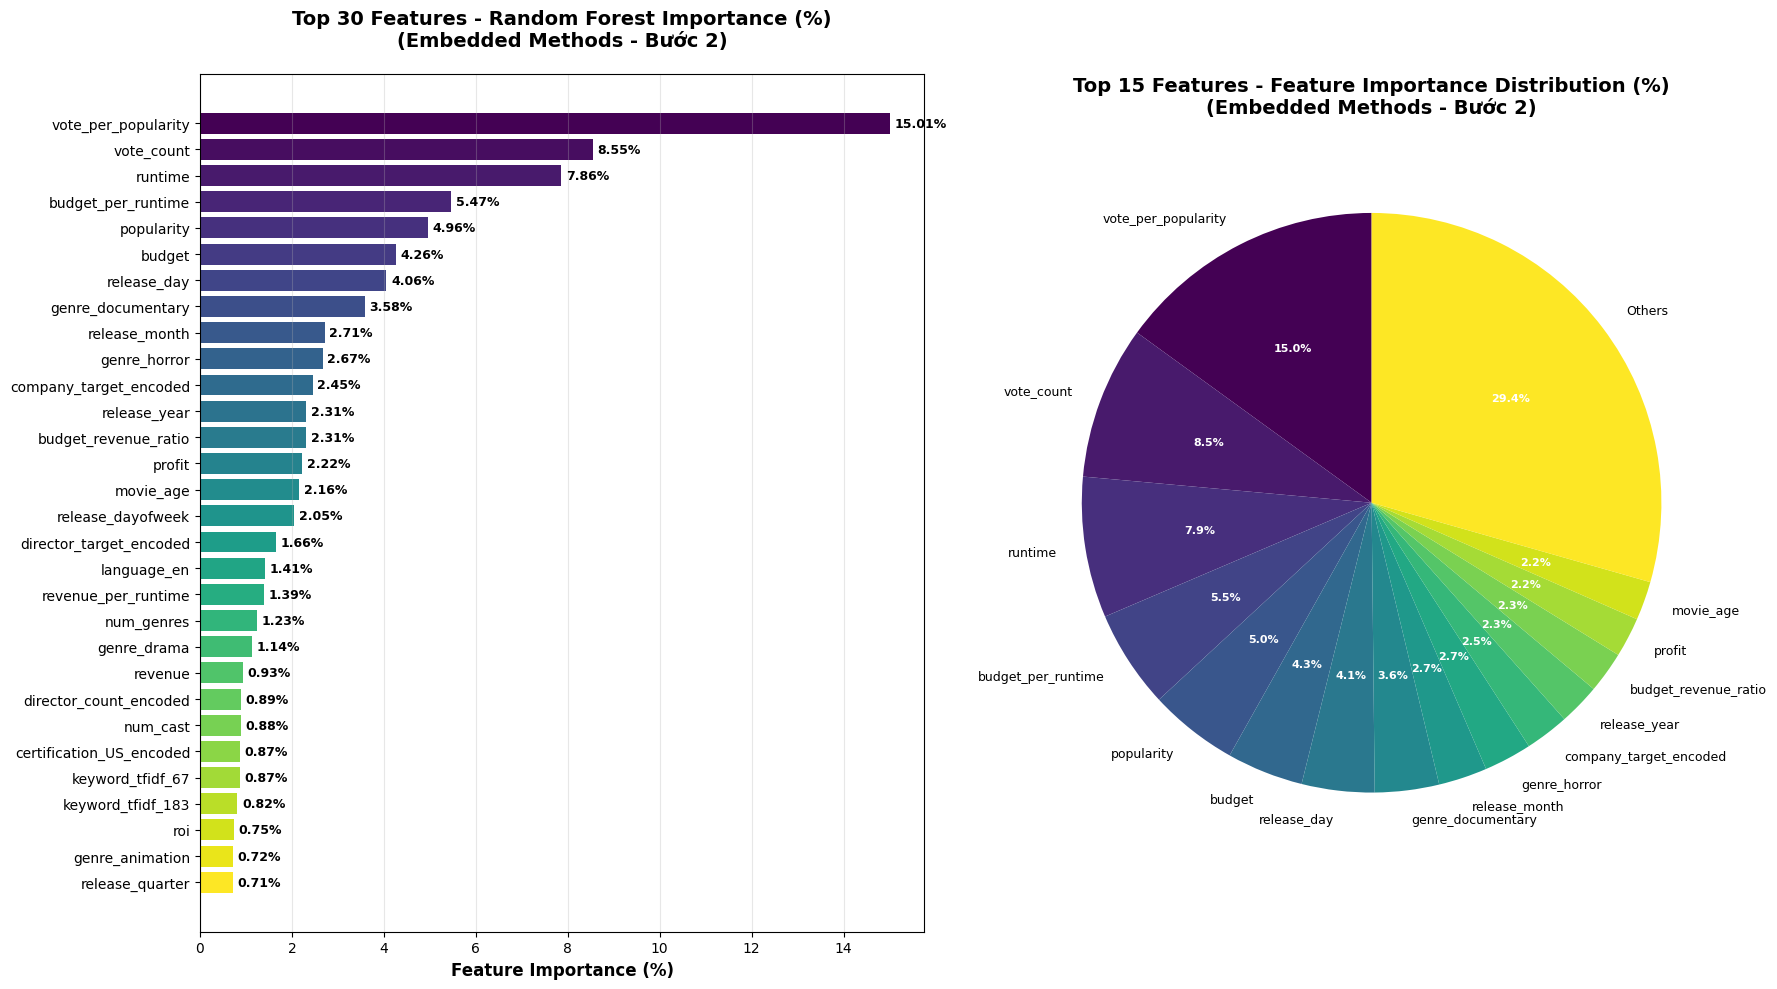


  Thống kê Feature Importance (Random Forest - Bước 2):
    - Tổng số features: 93
    - Tổng importance: 1.0000 (100%)
    - Mean importance: 1.08%
    - Max importance: 15.01%
    - Min importance: 0.03%

  Cumulative Importance:
    - Top 10 features chiếm: 59.13%
    - Top 20 features chiếm: 78.32%
    - Top 30 features chiếm: 86.89%

  Top 10 features quan trọng nhất (theo Random Forest - %):
     1. vote_per_popularity                     :  15.01% (importance: 0.1501)
     2. vote_count                              :   8.55% (importance: 0.0855)
     3. runtime                                 :   7.86% (importance: 0.0786)
     4. budget_per_runtime                      :   5.47% (importance: 0.0547)
     5. popularity                              :   4.96% (importance: 0.0496)
     6. budget                                  :   4.26% (importance: 0.0426)
     7. release_day                             :   4.06% (importance: 0.0406)
     8. genre_documentary                    

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Lasso (L1 Regularization) - Tự động chọn features
lasso = LassoCV(cv=5, random_state=42, max_iter=2000, n_jobs=-1)
lasso.fit(X_train, y_train)

# Lấy features có coefficient != 0
selected_features_lasso = X.columns[lasso.coef_ != 0].tolist()
print(f"  Lasso chọn: {len(selected_features_lasso)}/{len(X.columns)} features")
print(f"  Alpha (regularization): {lasso.alpha_:.6f}")
print(f"  Đã loại bỏ: {len(X.columns) - len(selected_features_lasso)} features (coefficient = 0)")

# 2.2. Random Forest Feature Importance
rf_embedded = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_embedded.fit(X_train, y_train)

# Lấy top N features dựa trên importance
n_features_rf = min(200, len(X.columns))  # Chọn top 200 hoặc tất cả nếu < 200
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_embedded.feature_importances_
}).sort_values('importance', ascending=False)

selected_features_rf = feature_importance_df.head(n_features_rf)['feature'].tolist()
print(f"  Random Forest chọn: {len(selected_features_rf)}/{len(X.columns)} features (top {n_features_rf})")

# Kết hợp Lasso và Random Forest (intersection hoặc union)
# Dùng union để giữ nhiều features hơn, sau đó sẽ filter tiếp
selected_features_embedded = list(set(selected_features_lasso) | set(selected_features_rf))
print(f" Kết hợp (union): {len(selected_features_embedded)} features")

X = X[selected_features_embedded]

# Visualization: Top Features từ Random Forest Feature Importance (Bước 2) - Theo phần trăm
print("\n2.3. Visualization Top Features từ Random Forest (theo phần trăm)...")

# Tính phần trăm importance
total_importance = feature_importance_df['importance'].sum()
feature_importance_df['importance_pct'] = (feature_importance_df['importance'] / total_importance * 100)

# Lấy top N features để visualize
top_n_visualize = 30
top_features_rf = feature_importance_df.head(top_n_visualize)

# Tạo figure với 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Subplot 1: Horizontal Bar Chart - Theo phần trăm
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features_rf)))
bars = ax1.barh(range(len(top_features_rf)), top_features_rf['importance_pct'], color=colors)
ax1.set_yticks(range(len(top_features_rf)))
ax1.set_yticklabels(top_features_rf['feature'], fontsize=10)
ax1.set_xlabel('Feature Importance (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'Top {top_n_visualize} Features - Random Forest Importance (%)\n(Embedded Methods - Bước 2)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()  # Hiển thị feature quan trọng nhất ở trên

# Thêm giá trị phần trăm trên mỗi bar
for i, (idx, row) in enumerate(top_features_rf.iterrows()):
    ax1.text(row['importance_pct'] + 0.1, i, f'{row["importance_pct"]:.2f}%', 
             va='center', fontsize=9, fontweight='bold')

# Subplot 2: Pie Chart - Top 15 features
ax2 = axes[1]
top_15 = feature_importance_df.head(15)
# Tính phần trăm cho "Others"
others_pct = feature_importance_df.iloc[15:]['importance_pct'].sum() if len(feature_importance_df) > 15 else 0

if others_pct > 0:
    pie_data = list(top_15['importance_pct']) + [others_pct]
    pie_labels = list(top_15['feature']) + ['Others']
else:
    pie_data = list(top_15['importance_pct'])
    pie_labels = list(top_15['feature'])

colors_pie = plt.cm.viridis(np.linspace(0, 1, len(pie_data)))
wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', 
                                    colors=colors_pie, startangle=90, textprops={'fontsize': 9})
ax2.set_title(f'Top 15 Features - Feature Importance Distribution (%)\n(Embedded Methods - Bước 2)', 
              fontsize=14, fontweight='bold', pad=20)

# Làm đậm phần trăm text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

plt.tight_layout()
plt.show()

# In thống kê theo phần trăm
print(f"\n  Thống kê Feature Importance (Random Forest - Bước 2):")
print(f"    - Tổng số features: {len(feature_importance_df)}")
print(f"    - Tổng importance: {total_importance:.4f} (100%)")
print(f"    - Mean importance: {feature_importance_df['importance_pct'].mean():.2f}%")
print(f"    - Max importance: {feature_importance_df['importance_pct'].max():.2f}%")
print(f"    - Min importance: {feature_importance_df['importance_pct'].min():.2f}%")

# Tính cumulative importance
feature_importance_df['cumulative_pct'] = feature_importance_df['importance_pct'].cumsum()
print(f"\n  Cumulative Importance:")
if len(feature_importance_df) > 9:
    print(f"    - Top 10 features chiếm: {feature_importance_df.iloc[9]['cumulative_pct']:.2f}%")
if len(feature_importance_df) > 19:
    print(f"    - Top 20 features chiếm: {feature_importance_df.iloc[19]['cumulative_pct']:.2f}%")
if len(feature_importance_df) > 29:
    print(f"    - Top 30 features chiếm: {feature_importance_df.iloc[29]['cumulative_pct']:.2f}%")

print(f"\n  Top 10 features quan trọng nhất (theo Random Forest - %):")
for i, (idx, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"    {i:2d}. {row['feature']:40s}: {row['importance_pct']:6.2f}% (importance: {row['importance']:.4f})")


### Bước 3: Correlation Check (Chỉ áp dụng cho Top Features)

Sau bước Embedded Methods, các features đã được chọn từ dataset phim có thể vẫn chứa nhiều features redundant:
- **Budget features**: `budget` (đã log transform) và `budget_per_runtime` có thể có correlation cao
- **Revenue features**: `revenue` (đã log transform) và `revenue_per_runtime` có thể có correlation cao
- **Genre features**: Một số genres có thể xuất hiện cùng nhau (ví dụ: Action và Adventure)
- **SVD components**: Các SVD components từ overview+tagline có thể có correlation với nhau
- **TF-IDF features**: Các từ khóa hoặc từ trong title có thể có correlation

Giữ lại cả hai features redundant sẽ:
- Tăng số chiều không cần thiết (ví dụ: từ 250 xuống 200)
- Có thể gây multicollinearity (ảnh hưởng đến linear models như Lasso, Ridge)
- Không cải thiện thông tin cho việc dự đoán vote_average

**Cách giải quyết:**
- **Correlation Matrix**: Tính correlation giữa các features đã chọn từ Embedded Methods
- **Threshold = 0.95**: Nếu hai features có correlation > 0.95, loại bỏ một trong hai
- **Giữ feature tốt hơn**: So sánh correlation với `vote_average`, giữ feature có correlation cao hơn
- **Ví dụ**: Nếu `budget` và `budget_per_runtime` có correlation > 0.95, giữ feature có correlation cao hơn với vote_average

**Kỹ thuật sử dụng:**
- Tính correlation matrix với `.corr().abs()` cho các features đã chọn
- Tìm các cặp features có correlation > 0.95
- So sánh correlation với `vote_average` để quyết định giữ feature nào
- Loại bỏ features redundant


In [33]:
correlation_matrix = X.corr().abs()

# Tìm các cặp features có correlation cao
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.95:  # Correlation > 0.95
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"  Tìm thấy {len(high_corr_pairs)} cặp features có correlation > 0.95")

# Loại bỏ một trong hai features có correlation cao
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    # Giữ feature có correlation cao hơn với target
    corr1 = abs(X[feat1].corr(y))
    corr2 = abs(X[feat2].corr(y))
    if corr1 < corr2:
        features_to_remove.add(feat1)
    else:
        features_to_remove.add(feat2)

selected_features_corr = [f for f in X.columns if f not in features_to_remove]
print(f"  Sau Correlation Check: {len(selected_features_corr)}/{len(X.columns)} features")
print(f"  Đã loại bỏ: {len(features_to_remove)} features redundant")

X = X[selected_features_corr]

# Cập nhật train/test split với features mới
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


  Tìm thấy 6 cặp features có correlation > 0.95
  Sau Correlation Check: 87/93 features
  Đã loại bỏ: 6 features redundant


### Bước 4: Wrapper Method (RFE / Forward Selection) - Bước tinh chỉnh cuối

Sau các bước trên, vẫn cần một bước tinh chỉnh cuối cùng để chọn ra ~100 features tối ưu nhất cho việc dự đoán `vote_average`:
- **Embedded methods** đã chọn nhiều features tiềm năng (ví dụ: 250 features)
- **Correlation check** đã loại bỏ redundant (ví dụ: còn 200 features)
- Nhưng vẫn còn một số features không cần thiết hoặc có thể thiếu một số features quan trọng
- Cần một phương pháp wrapper để đánh giá chính xác dựa trên model performance cho bài toán dự đoán rating

Ví dụ: Có thể một số SVD components hoặc TF-IDF features không quan trọng cho rating, hoặc một số genre features ít quan trọng hơn các features khác.

**Cách giải quyết:**

Sử dụng **Wrapper Methods** - đánh giá features dựa trên model performance khi dự đoán vote_average:
- **RFE (Recursive Feature Elimination)**:
  - Sử dụng Random Forest để dự đoán vote_average
  - Loại bỏ features ít quan trọng nhất từng bước (step=1)
  - Chọn top 100 features cuối cùng
  - Ví dụ: Loại bỏ các SVD components hoặc TF-IDF features ít quan trọng
- **Forward Selection**:
  - Bắt đầu từ tập rỗng, thêm features từng cái một
  - Mỗi bước chọn feature cải thiện R² score tốt nhất
  - Dừng khi đạt 80 features hoặc không cải thiện thêm
  - Phù hợp để tìm subset nhỏ gọn và hiệu quả
- **So sánh và chọn**: So sánh R² score trên test set, chọn phương pháp cho performance tốt hơn

**Kỹ thuật sử dụng:**
- **RFE**: Sử dụng `RFE` với Random Forest regressor, `n_features_to_select=100`, `step=1`
- **Forward Selection**: Sử dụng `SequentialFeatureSelector` với `direction='forward'`, `n_features_to_select=80`
- **Performance comparison**: So sánh R² score và RMSE trên test set khi dự đoán vote_average
- **Feature Importance**: Tính feature importance từ model cuối cùng để hiểu features nào quan trọng nhất cho rating


In [34]:
# 4.1. Recursive Feature Elimination (RFE)
n_features_to_select = 100  # Chọn top 100 features
rf_rfe = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf_rfe, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train, y_train)

selected_features_rfe = X.columns[rfe.get_support()].tolist()
print(f"  RFE chọn: {len(selected_features_rfe)}/{len(X.columns)} features")

# 4.2. Forward Selection (Sequential Feature Selector)
# Forward Selection chậm hơn, chỉ chạy nếu số features không quá nhiều
if len(X.columns) <= 150:
    n_features_forward = min(80, len(X.columns))
    forward_selector = SequentialFeatureSelector(
        estimator=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        n_features_to_select=n_features_forward,
        direction='forward',
        cv=3,
        n_jobs=-1
    )
    forward_selector.fit(X_train, y_train)
    selected_features_forward = X.columns[forward_selector.get_support()].tolist()
    print(f"  Forward Selection chọn: {len(selected_features_forward)}/{len(X.columns)} features")
    
    # So sánh performance của RFE và Forward Selection
    rf_rfe_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_forward_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
    rf_rfe_final.fit(X_train[selected_features_rfe], y_train)
    rf_forward_final.fit(X_train[selected_features_forward], y_train)
    
    score_rfe = rf_rfe_final.score(X_test[selected_features_rfe], y_test)
    score_forward = rf_forward_final.score(X_test[selected_features_forward], y_test)
    
    print(f"\n  So sánh performance:")
    print(f"    RFE R² score: {score_rfe:.4f}")
    print(f"    Forward Selection R² score: {score_forward:.4f}")
    
    # Chọn phương pháp tốt hơn
    if score_forward > score_rfe:
        selected_features_final = selected_features_forward
        print(f"  → Chọn Forward Selection (R² cao hơn)")
    else:
        selected_features_final = selected_features_rfe
        print(f"  → Chọn RFE (R² cao hơn)")
else:
    selected_features_final = selected_features_rfe
    print(f" Bỏ qua Forward Selection (quá nhiều features: {len(X.columns)})")

X_final = X[selected_features_final]

# Fit model cuối cùng để lấy feature importance
rf_final = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_final.fit(X_train[selected_features_final], y_train)

# Tính feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features_final,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n  Top 20 features quan trọng nhất (sau tất cả các bước):")
for i, row in feature_importance.head(20).iterrows():
    print(f" {row['feature']}: {row['importance']:.4f}")


  RFE chọn: 87/87 features
  Forward Selection chọn: 80/87 features

  So sánh performance:
    RFE R² score: 0.2791
    Forward Selection R² score: 0.2728
  → Chọn RFE (R² cao hơn)

  Top 20 features quan trọng nhất (sau tất cả các bước):
 vote_per_popularity: 0.2248
 runtime: 0.0796
 popularity: 0.0640
 budget_per_runtime: 0.0570
 budget: 0.0443
 release_day: 0.0408
 release_year: 0.0394
 budget_revenue_ratio: 0.0366
 genre_documentary: 0.0358
 release_month: 0.0314
 company_target_encoded: 0.0267
 genre_horror: 0.0265
 release_dayofweek: 0.0204
 director_target_encoded: 0.0171
 revenue_per_runtime: 0.0133
 language_en: 0.0132
 num_genres: 0.0129
 roi: 0.0120
 genre_drama: 0.0117
 director_count_encoded: 0.0101


In [35]:
# Tạo DataFrame cuối cùng với features đã chọn
df_final = pd.concat([X_final, y], axis=1)
print(f"  DataFrame cuối cùng: {df_final.shape}")
print(f"  - Features: {df_final.shape[1] - 1}")
print(f"  - Target: {target_col}")
print(f"  - Samples: {df_final.shape[0]}")

# Đánh giá model performance
print(f"  Model Performance (Random Forest):")
y_pred = rf_final.predict(X_test[selected_features_final])
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"  - R² Score: {r2:.4f}")
print(f"  - RMSE: {rmse:.4f}")


  DataFrame cuối cùng: (8000, 88)
  - Features: 87
  - Target: vote_average
  - Samples: 8000
  Model Performance (Random Forest):
  - R² Score: 0.2791
  - RMSE: 1.2670


In [36]:
# Lưu dữ liệu đã feature selection
output_path = '../data/feature_engineering/fe_data_selected.csv'
df_final.to_csv(output_path, index=False)

# Lưu danh sách features đã chọn
features_list_path = '../data/feature_engineering/selected_features.txt'
with open(features_list_path, 'w') as f:
    f.write("# Feature Selection Results\n")
    f.write(f"# Total features: {len(selected_features_final)}\n")
    f.write(f"# Reduced from: {len(feature_cols)} features\n")
    f.write(f"# Reduction: {((len(feature_cols) - len(selected_features_final)) / len(feature_cols) * 100):.1f}%\n\n")
    for feat in selected_features_final:
        f.write(f"{feat}\n")

# Lưu feature importance
importance_path = '../data/feature_engineering/feature_importance.csv'
feature_importance.to_csv(importance_path, index=False)